In [82]:
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from ast import literal_eval
from surprise import *
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

In [83]:
user_profile = pd.read_csv("data/User_Profile_Null_Handled.csv")

In [84]:
user_profile["Sub_Update_Status"].value_counts()

NO_INFO                30250
Promotion Upgrade       7369
Promotion Downgrade     4975
Name: Sub_Update_Status, dtype: int64

In [85]:
data=user_profile.iloc[:,[1,3,11,14,18,23,25,43,48,53,59,61,34]]
#data.rename(columns={"Sub_Type":"label"},inplace=True)
data = pd.get_dummies(data, prefix=['Sub_Update'], columns=['Sub_Update_Status'])
# data.drop('Sub_Update_Status', axis=1)

# Label encode class
# le = LabelEncoder()
# data['label'] = le.fit_transform(data.Sub_Type.values)
data = data.drop(['Sub_Update_NO_INFO'], axis=1)

In [86]:
data.fillna(0,inplace=True)
data_dim=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,12,13]]

## PCA Based rating calculation

In [87]:
pc=PCA(n_components=12) 
pc.fit(data_dim)

PCA(n_components=12)

In [88]:
#How mucb variance, captured together
pc.explained_variance_ratio_.cumsum()

array([0.31595666, 0.56946394, 0.72630511, 0.86585636, 0.93064071,
       0.96783583, 0.98094293, 0.98846729, 0.99519398, 0.99953125,
       0.99995611, 1.        ])

In [89]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca = PCA(n_components=1)
pca.fit(data_dim)
reduced_data = pca.fit_transform(data_dim)
results_df = pd.DataFrame(reduced_data,columns=['ratings'])

In [90]:
# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_df[['ratings']] = scaler.fit_transform(results_df[['ratings']])

In [91]:
data=pd.concat([data,results_df],axis=1)

In [92]:
data.rename(columns={"Sub_Type":"package"}, inplace=True)
data = data[["ACCOUNT_NUM.hash","package","ratings"]]
data

,ACCOUNT_NUM.hash,package,ratings
0,9efd917f18bb5c966953b4227ddbaf43,TRIPLE_PLAY,0.403696
1,2240d11b0d9ee8f6d9e8972c6190aa42,SINGLE_PLAY,0.251039
2,cff00495fd556a417e2838e27465d749,DOUBLE_PLAY_BV,0.374582
3,d00dacd8fc98c1726d6a4e9f28f8e579,TRIPLE_PLAY,0.301764
4,a3ee54787617510a616dfcb52c28941b,TRIPLE_PLAY,0.384823
...,...,...,...
42589,7052930957f02ad914dbd24fdcd04fed,DOUBLE_PLAY_BV,0.399498
42590,c217fb1b44642e79e56af9111e9c00b2,TRIPLE_PLAY,0.879634
42591,5e94646aa83bb9d7fab98620405517cb,DOUBLE_PLAY_BV,0.247882
42592,6801a82b67b7fb942242b7aca5ba022c,DOUBLE_PLAY_BV,0.441890


## Interaction Matrix

In [93]:
# create a histogram of all the interactions by all the users present in the dataset
def create_interaction_matrix(data):
    interactions = data.groupby('ACCOUNT_NUM.hash').count()['package']
    plt.hist(interactions,bins=20)
    plt.show()

    # create the user item matrix using the ratings dataset - Hint: try using pivot function 
    interactions_metrix = data.pivot_table(index="ACCOUNT_NUM.hash", columns="package", values="ratings",aggfunc=np.sum)
    # replace all the missing values with zero
    return interactions_metrix.fillna(0)

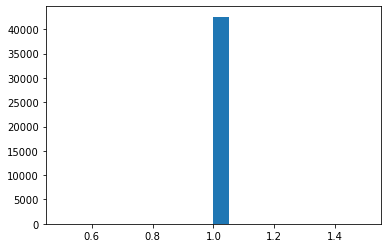

package,4G,DOUBLE_PLAY_BV,DOUBLE_PLAY_PV,SINGLE_PLAY,TRIPLE_PLAY
ACCOUNT_NUM.hash,,,,,
0003102d10a11c8f2f0f241f00a36b2d,0.0,0.000000,0.000000,0.000000,0.713319
0003df7598926f578f53ecd9e424f3c9,0.0,0.330602,0.000000,0.000000,0.000000
00092b1fd47eb05d000a3553ae072056,0.0,0.000000,0.000000,0.000000,0.413539
00094326efae1d73371d118204e12e46,0.0,0.000000,0.343136,0.000000,0.000000
000ae59b7eb91e778f22e3f07495f4f9,0.0,0.416101,0.000000,0.000000,0.000000
...,...,...,...,...,...
fff9148b195a844454cf5b07c2fccbcb,0.0,0.000000,0.090593,0.000000,0.000000
fffaeeddaabbd2868c183d8884b2a98d,0.0,0.000000,0.000000,0.000000,0.449490
fffd0b8541e9f62496092d2ea8609135,0.0,0.000000,0.000000,0.000000,0.514746


In [94]:
create_interaction_matrix(data)

In [95]:
#X = interactions_metrix.values.T

## Function definition

In [96]:
def train_test_splitter(data):
    reader = Reader(rating_scale=(0, 1))
    data_model = Dataset.load_from_df(data, reader)
    return data_model,train_test_split(data_model, test_size=.20)

In [97]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

In [98]:
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:5]
        

    return top_n

In [99]:
# calculate NDCG
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

In [100]:
def top_n_pred(predictions):
    top_n = get_top_n(predictions, n=3)
    #print(top_n)
    users_est = defaultdict(list)
    users_true=defaultdict(list)
    rec_for_user=defaultdict(list)
    for uid, user_ratings in top_n.items():
        users_est[uid].append([est for (_, est,_) in user_ratings])
        users_true[uid].append([true_r for (_,_,true_r) in user_ratings])
        rec_for_user[uid].append([iid for (iid,_,_) in user_ratings])
    return top_n, users_est, users_true, rec_for_user

In [101]:
def calc_ndcg(users_true,users_est):
    ndcg_list=[]
    for uid in top_n:
        
        for i in users_true[uid]:
            y_true=np.asarray(i)#.reshape(-1,1)
        for i in users_est[uid]:
            y_pred=np.asarray(i)#.reshape(-1,1)
        
            ndcg_list.append(ndcg1(y_true, y_pred, k=None))

    ndcg_list = [i for i in ndcg_list if str(i) != 'nan']
    ndgc_rate = np.mean(ndcg_list)
    return ndcg_list, ndgc_rate

## Collobarative Recommenders

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42594 entries, 0 to 42593
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCOUNT_NUM.hash  42594 non-null  object 
 1   package           42594 non-null  object 
 2   ratings           42594 non-null  float64
dtypes: float64(1), object(2)
memory usage: 998.4+ KB


In [103]:
data = data[data["ratings"] > 0]

In [105]:
data_model, (trainset, testset) = train_test_splitter(data)

## SVD Model

In [106]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
svd_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1772  0.1776  0.1778  0.1757  0.1754  0.1767  0.0010  
MAE (testset)     0.1403  0.1411  0.1413  0.1396  0.1404  0.1405  0.0006  
Fit time          2.04    2.05    1.98    2.03    2.06    2.03    0.03    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


In [107]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [108]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [109]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [110]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [111]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
2538,50f1aaf9203d4106d6e9663f2f54258a,DOUBLE_PLAY_BV,0.390865,0.390790,{'was_impossible': False},0,12600,0.000075
4405,1f8be202ae50b5d1b39ce719d9a04eb4,TRIPLE_PLAY,0.513389,0.513476,{'was_impossible': False},0,12762,0.000087
7080,c395d3d9a551864d2ecf21950eebcadb,DOUBLE_PLAY_BV,0.390890,0.390790,{'was_impossible': False},0,12600,0.000100
2345,d3b51a6dd82d7a3c6c3a60dd511ce75a,TRIPLE_PLAY,0.513620,0.513476,{'was_impossible': False},0,12762,0.000144
8130,78d55b3934d42f3bce9a4dc41676219b,DOUBLE_PLAY_BV,0.390972,0.390790,{'was_impossible': False},0,12600,0.000182
2368,000f1aa5bd19fc28f99766f1b85a6be3,DOUBLE_PLAY_BV,0.391003,0.390790,{'was_impossible': False},0,12600,0.000213
3944,0a4ed644d21fbaee7aa5ac3ec938c9f6,DOUBLE_PLAY_BV,0.390574,0.390790,{'was_impossible': False},0,12600,0.000217
4610,5475288d99a3866f801db7e6e0773b60,DOUBLE_PLAY_BV,0.390546,0.390790,{'was_impossible': False},0,12600,0.000245
480,8fb36ea3f4604f4e60ea72e3875b9eb5,DOUBLE_PLAY_BV,0.391057,0.390790,{'was_impossible': False},0,12600,0.000267
5577,22b780067608fcd7d6030ad485d7025f,TRIPLE_PLAY,0.513743,0.513476,{'was_impossible': False},0,12762,0.000267


In [112]:
rmse = accuracy.rmse(predictions)
print("SVD RMSE -->",rmse)
print("SVD Accuracy -->",1-rmse)

RMSE: 0.1772
RMSE --> 0.17718465584154022
Accuracy --> 0.8228153441584598


In [113]:
data_triplet = data.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"package":"Actual_Subscription","iid":"SVD_recommendation","err":"SVD_error"}, inplace = True)

## SlopeOne

In [114]:
# We'll use the SlopeOne algorithm.
algo = SlopeOne()

# Run 5-fold cross-validation and print results
so_validate =cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2051  0.2053  0.2047  0.2023  0.2045  0.2044  0.0011  
MAE (testset)     0.1607  0.1603  0.1600  0.1578  0.1599  0.1597  0.0010  
Fit time          0.33    0.35    0.34    0.33    0.34    0.34    0.01    
Test time         0.06    0.06    0.06    0.28    0.06    0.10    0.09    


In [115]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [116]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [117]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [118]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [119]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
648,78992e49c15cc5701e92a3768fdbd70b,TRIPLE_PLAY,0.407579,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12762,0.000061
1298,9caa84cd5c5e530f4d655ee08facb7b2,DOUBLE_PLAY_BV,0.407570,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000070
3740,573eeb92a1dd657d4e8659c1f1222a1a,DOUBLE_PLAY_BV,0.407736,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000096
7159,1fcbbb4a01ed893ff0783dfd8c0f180b,TRIPLE_PLAY,0.407739,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12762,0.000100
4298,e9c95b5fd9e55a037f7fd7eb627d85a3,DOUBLE_PLAY_BV,0.407752,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000112
1186,3172a69d47bb0057c940b995846f9c9f,TRIPLE_PLAY,0.407772,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12762,0.000132
2542,4e059b1d0a7e87404a2d44d0df0e76f0,TRIPLE_PLAY,0.407797,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12762,0.000157
5449,441e119f478200b468fe8234c4809f8d,DOUBLE_PLAY_BV,0.407798,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000158
1279,5d02ecf6c1bbd02382d22928fa0997b7,DOUBLE_PLAY_BV,0.407437,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000202
5520,fabd9dab5c89545f34a3a54977a13f3c,DOUBLE_PLAY_BV,0.407391,0.40764,"{'was_impossible': True, 'reason': 'User and/o...",0,12600,0.000249


In [120]:
rmse = accuracy.rmse(predictions)
print("SlopeOne RMSE -->",rmse)
print("SlopeOne Accuracy -->",1-rmse)

RMSE: 0.2052
RMSE --> 0.20517137961525037
Accuracy --> 0.7948286203847497


In [121]:
data_triplet = data_triplet.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"iid":"SlopeOne_recommendation","err":"SlopeOne_error"}, inplace = True)

## Matrix factorization (NMF)

In [122]:
# We'll use the SlopeOne algorithm.
algo = NMF()

# Run 5-fold cross-validation and print results
nmf_validate =cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2022  0.2053  0.2043  0.2063  0.2039  0.2044  0.0014  
MAE (testset)     0.1575  0.1608  0.1594  0.1616  0.1594  0.1597  0.0014  
Fit time          4.43    4.26    4.30    4.15    4.12    4.25    0.11    
Test time         0.27    0.05    0.05    0.05    0.25    0.13    0.10    


In [123]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [124]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [125]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 1.0


In [126]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [127]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
648,78992e49c15cc5701e92a3768fdbd70b,TRIPLE_PLAY,0.407579,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12762,0.000061
1298,9caa84cd5c5e530f4d655ee08facb7b2,DOUBLE_PLAY_BV,0.407570,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000070
3740,573eeb92a1dd657d4e8659c1f1222a1a,DOUBLE_PLAY_BV,0.407736,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000096
7159,1fcbbb4a01ed893ff0783dfd8c0f180b,TRIPLE_PLAY,0.407739,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12762,0.000100
4298,e9c95b5fd9e55a037f7fd7eb627d85a3,DOUBLE_PLAY_BV,0.407752,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000112
1186,3172a69d47bb0057c940b995846f9c9f,TRIPLE_PLAY,0.407772,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12762,0.000132
2542,4e059b1d0a7e87404a2d44d0df0e76f0,TRIPLE_PLAY,0.407797,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12762,0.000157
5449,441e119f478200b468fe8234c4809f8d,DOUBLE_PLAY_BV,0.407798,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000158
1279,5d02ecf6c1bbd02382d22928fa0997b7,DOUBLE_PLAY_BV,0.407437,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000202
5520,fabd9dab5c89545f34a3a54977a13f3c,DOUBLE_PLAY_BV,0.407391,0.40764,"{'was_impossible': True, 'reason': 'User and i...",0,12600,0.000249


In [128]:
rmse = accuracy.rmse(predictions)
print("MF RMSE -->",rmse)
print("MF Accuracy -->",1-rmse)

RMSE: 0.2052
RMSE --> 0.20517137961525037
Accuracy --> 0.7948286203847497


In [129]:
data_triplet = data_triplet.merge(df[["uid","iid","err"]], left_on="ACCOUNT_NUM.hash", right_on ="uid", how="left")
data_triplet.dropna(subset=["uid"],inplace=True)
data_triplet.drop("uid", axis=1, inplace = True)
data_triplet.rename(columns={"iid":"MF_recommendation","err":"MF_error"}, inplace = True)

In [130]:
data_triplet

,ACCOUNT_NUM.hash,Actual_Subscription,ratings,SVD_recommendation,SVD_error,SlopeOne_recommendation,SlopeOne_error,MF_recommendation,MF_error
0,d46578e724259a3706db0c910a934581,DOUBLE_PLAY_BV,0.289112,DOUBLE_PLAY_BV,0.101678,DOUBLE_PLAY_BV,0.118528,DOUBLE_PLAY_BV,0.118528
1,590a953fdfadb4a4a33e1b57af01e72c,SINGLE_PLAY,0.244405,SINGLE_PLAY,0.020904,SINGLE_PLAY,0.163235,SINGLE_PLAY,0.163235
2,cae036d41e5ae321b173e0f851ee247c,DOUBLE_PLAY_BV,0.391783,DOUBLE_PLAY_BV,0.000992,DOUBLE_PLAY_BV,0.015857,DOUBLE_PLAY_BV,0.015857
3,8fb3927f2227d75fe57e16a63c14f709,DOUBLE_PLAY_PV,0.377820,DOUBLE_PLAY_PV,0.001833,DOUBLE_PLAY_PV,0.029820,DOUBLE_PLAY_PV,0.029820
4,317395da96fc088bceb0d7676615aa59,SINGLE_PLAY,0.244910,SINGLE_PLAY,0.021408,SINGLE_PLAY,0.162730,SINGLE_PLAY,0.162730
...,...,...,...,...,...,...,...,...,...
8514,0f4a6e79ace9c883703948afe4d4a620,SINGLE_PLAY,0.000692,SINGLE_PLAY,0.222809,SINGLE_PLAY,0.406948,SINGLE_PLAY,0.406948
8515,0ea6e72e341e1608e5f23d305bc4d9b1,DOUBLE_PLAY_BV,0.365433,DOUBLE_PLAY_BV,0.025357,DOUBLE_PLAY_BV,0.042206,DOUBLE_PLAY_BV,0.042206
8516,1bfd09d01f55a955b5453d7aa8292f93,DOUBLE_PLAY_BV,0.249541,DOUBLE_PLAY_BV,0.141249,DOUBLE_PLAY_BV,0.158098,DOUBLE_PLAY_BV,0.158098
8517,bf06f38320e11843132d13c87566d5d4,TRIPLE_PLAY,0.396524,TRIPLE_PLAY,0.116952,TRIPLE_PLAY,0.011116,TRIPLE_PLAY,0.011116


## KNN with Means recommender

In [131]:
# We'll use the SlopeOne algorithm.
algo = KNNWithMeans()

# Run 5-fold cross-validation and print results
knn_validate = cross_validate(algo, data_model, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

In [ ]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

In [ ]:
# Let's build a pandas dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

In [ ]:
rmse = accuracy.rmse(predictions)
print("KNN Means RMSE -->",rmse)
print("KNN Means Accuracy -->",1-rmse)

## Factorization Machines

## Benchmark lgorithms

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), KNNBaseline(), KNNWithMeans(), CoClustering(), NMF()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_model, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
val_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
val_df

In [ ]:
fig,ax = plt.subplots(figsize=(13,8))
ax.plot(so_validate["test_rmse"], color='blue')
ax.plot(svd_validate["test_rmse"], color='green')
ax.plot(knn_validate["test_rmse"], color='orange')
ax.plot(nmf_validate["test_rmse"], color='red')
ax.plot(so_validate["test_mae"], linestyle='dashdot', color='blue')
ax.plot(svd_validate["test_mae"], linestyle='dashdot', color='green')
ax.plot(knn_validate["test_mae"], linestyle='dashdot', color='orange')
ax.plot(nmf_validate["test_mae"], linestyle='dashdot', color='red')
# plt.xticks(np.arange(0, 30, 0.5))
plt.title("Boradband Packages Recommender", loc="center")
plt.legend(["RMSE: SlopeOne","RMSE: SVD","RMSE: KNNwithMeans","RMSE: NMF",
           "MAE: SlopeOne","MAE: SVD","MAE: KNNwithMeans","MAE: NMF"])

## Best Accuracy Model

## Model Stacking approach (Ensambling)

## Busines Rule filtration

## Store resutls

In [113]:
data_triplet.to_csv("data/up-selling-scored/CF_scored_and_eval.csv")